1절에서는 합성곱, 필터, 패딩, 스트라이드, 풀링 등이 있다.  
텐서플로를 사용하면 합성곱, 패딩, 풀링 크기를 직접 계산할 필요가 없다. 복잡한 계산은 케라스 API에 위임하여 직관적인 신경망 설계가 가능하다.  
  
이번 절에서는 텐서플로 케라스 API를 사용해 패션 MNIST 데이터를 합성곱 신경망으로 분류해보도록 한다.

### 패션 MNIST 데이터 불러오기  
먼저 주피터 노트북에서 케라스 API를 사용해 패션 MNIST 데이터를 불러오고 전처리를 진행한다.  
데이터 스케일을 0~255 사이에서 0~1 사이로 바꾸고 훈련 세트와 검증 세트로 나눈다.  
  
완전 연결 신경망에서는 입력 이미지를 밀집층에 연결하기 위해 일렬로 펼쳐야한다. 이 작업을 위해 넘파이 reshape() 메서드를 사용하거나 Flatten 클래스를 사용했다.  
하지만 합성곱 신경망은 2차원 이미지를 그대로 사용하기 때문에 일렬로 펼치지 않는다.  
  
8장 1절에서 언급되었듯이 입력 이미지는 항상 깊이(채널) 차원이 있어야 한다. 흑백 이미지의 경우 채널 차원이 없는 2차원 배열이지만 Conv2D 층을 사용하기 위해 마지막에 이 채널 차원을 추가해야 한다. 넘파이 reshape() 메서드를 사용해 전체 배열 차원을 그대로 유지하면서 마지막에 차원을 간단히 추가할 수 있다.

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) =\
    keras.datasets.fashion_mnist.load_data()
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

(48000, 28, 28) 크기인 train_input, (48000, 28, 28, 1) 크기인 train_scaled가 되었다.  
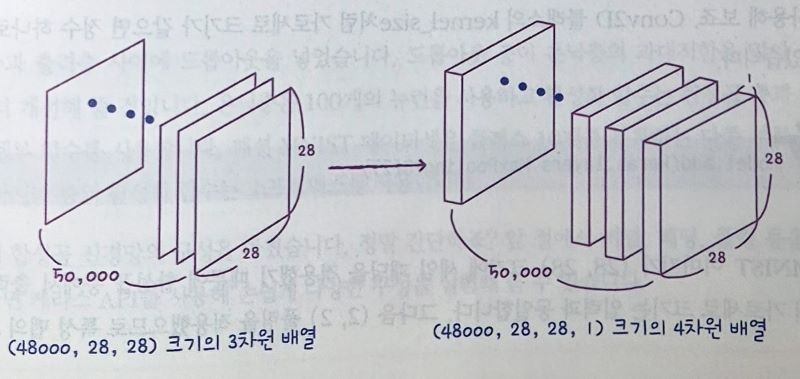

### 합성곱 신경망 만들기  
전형적인 합성곱 신경망의 구조는 합성곱 층으로 이미지에서 특징을 감지한 후 말집층으로 클래스에 따른 분류 확률을 계산한다.  
케라스의 Sequential 클래스를 사용해 순서대로 이 구조를 정의하자.  
  
먼저 Sequential 클래스의 객체를 만들고 첫 번째 합성곱 층인 Conv2D를 추가한다. 이 클래스는 다른 층 클래스와 마찬가지로 keras.layer 패키지 아래에 있다.  
여기에서는 이전 장에서 보았던 모델의 add() 메서드를 사용해 층을 하나씩 차례대로 추가한다.

In [2]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28,28,1)))

이 합성곱 층은 32개의 필터를 사용한다. 커널의 크기는 (3, 3)이고 렐루 활성화 함수와 세임 패딩을 사용한다.  
  
완전 연결 신경망에서처럼 케라스 신경망의 첫 번째 층에서 입력의 차원을 지정해 주어야 한다. 앞서 패션 MNIST 이미지를 (28, 28)에서 (28, 28, 1)로 변경했다.  
input_shape 매개변수를 이 값으로 지정한다.  
  
그 다음 풀링 층을 추가한다. 케라스는 최대 풀링과 평균 풀링을 keras.layers 패키지 아래 MaxPooling2D와 AveragePooling2D 클래스로 제공한다. 전형적인 풀링 크기인 (2, 2) 풀링을 사용하자. Conv2D 클래스의 kernel_size처럼 가로세로 크기가 같으면 정수 하나로 지정할 수 있다.

In [3]:
model.add(keras.layers.MaxPooling2D(2))

패션 MNIST 이미지가 (28, 28) 크기에 세임 패딩을 적용했기 때문에 합성곱 층에서 출력된 특성 맵의 크기의 가로세로 크기는 입력과 동일하다. 그 다음 (2, 2) 풀링을 적용했으므로 특성 맵의 크기는 절반으로 줄어든다. 합성곱 층에서 32개의 필터를 사용했기 때문에 이 특성 맵의 깊이는 32가 된다.  
  
따라서 최대 풀링을 통과한 특성 맵의 크기는 (14, 14, 32)가 될 것이다. 나중에 각 층의 크기를 summary() 메서드로 확인해 보자.  
첫 번째 합성곱 - 풀링 층 다음에 두 번째 합성곱-풀링 층을 추가해 보자. 두 번째 합성곱-풀링 층은 첫 번째와 거의 동일하다. 필터의 개수를 64개로 늘린 점이 다르다.

In [4]:
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))

첫 번째 합성곱-풀링 층과 마찬가지로 이 합성곱 층은 세임 패딩을 사용한다. 따라서 입력의 가로세로 크기를 줄이지 않는다. 이어지는 풀링 층에서 이 크기를 절반으로 줄인다. 64개의 필터를 사용했으므로 최종적으로 만들어지는 특성 맵의 크기는 (7, 7, 64)가 된다.  
  
이어서 3차원 특성 맵을 일렬로 펼친다. 마지막에 10개의 뉴런을 가진 (밀집) 출력층에서 확률을 계산하기 때문이다. 여기에서는 특성 맵을 일렬로 펼쳐서 바로 출력층에 전달하지 않고 중간에 하나의 밀집 은닉층을 하나 더 두기로 한다.  
즉 Flatten 클래스 다음에 Dense 은닉층, 마지막으로 Dense 출력층의 순서로 구성한다.

In [5]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation = 'relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))

은닉층과 출력층 사이에 드롭아웃을 넣었다. 드롭아웃 층이 은닉층의 과대 적합을 막아 성능을 조금 더 개선해 줄 것이다. 은닉층은 100개의 뉴런을 사용하고 활성화 함수는 합성곱 층과 마찬가지로 렐루 함수를 사용한다.  
패션 MNIST 데이터셋은 클래스 10개를 분류하는 다중 분류 문제이므로 마지막 층의 활성화 함수는 소프트맥스 함수를 사용한다.  
  
합성곱 신경망의 구성을 마쳤다.  
summary() 메서드로 구조를 출력해 보자.

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

summary() 메서드의 출력 결과를 보면 합성곱 층과 풀링 층의 효과가 잘 나타나 있다.  
첫 번째 합성곱 층을 통과하면서 특성 맵의 깊이는 32가 되고 두 번째 합성곱에서 특성 맵의 크기가 64로 늘어난다. 반면 특성 맵의 가로세로 크기는 첫 번째 풀링 층에서 절반으로 줄어들고 두 번째 풀링 층에서 다시 절반으로 줄어든다. 따라서 최종 특성 맵의 크기는 (7, 7, 64)이다.  
  
완전 연결 신경망에서 했던 것 처럼 모델 파라미터 개수를 계산해 보자.  
첫 번째 합성곱 층은 32개의 필터를 가지고 있고 크기가 (3,3), 깊이가 1이다. 또 필터마다 하나의 절편이 있다.  
따라서 총 3 x 3 x 1 x 32 + 32 = 320개의 파라미터가 있다.  
  
두 번째 합성곱 64개의 필터를 사용하고 크기가 (3,3), 깊이가 32이다. 필터마다 하나의 절편이 있다.  
따라서 총 3 x 3 x 32 x 64 + 64 = 18,496개의 파라미터가 있다.  
층의 구조를 잘 이해하고 있는지 확인하려면 파라미터 개수를 계산해보는 것이 좋다.  
  
Flatten 클래스에서 (7,7,64) 크기의 특성 맵을 1차원 배열로 펼치면 (3136,) 크기의 배열이 된다.  
이를 100개의 뉴런과 완전히 연결해야 하므로 모델 파라미터 수는 3,136 x 100 + 100 = 313,700개이다.  
마지막 출력층의 모델 파라미터 개수는 1,010개이다.  
  
케라스는 summary() 메서드 외에 층의 구성을 그림으로 표현해 주는 plot_model() 함수를 keras.utils 패키지에서 제공한다. 이 함수에서 만든 model 객체를 넣어 호출해 보자.

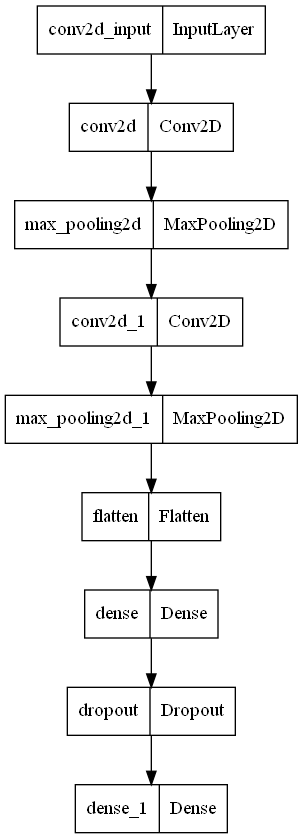

In [7]:
keras.utils.plot_model(model)

네모 상자 안의 내용 중 왼쪽에는 층의 이름이 쓰여 있고 오른쪽에는 클래스가 나타난다. 맨 처음에 나오는 InputLayer 클래스는 케라스가 자동으로 추가해 주는 것으로 입력층의 역할을 한다.  
이 입력층은 첫 번째 Conv2D 클래스에 추가한 input_shape 매개변수를 사용한다.  
  
plot_model() 함수의 show_shapes 매개변수를 True로 설정하면 이 그림에 입력과 출력의 크기를 표시해 준다. 또한 to_file 매개변수에 파일 이름을 지정하면 출력한 이미지를 파일로 저장한다.  
dpu 매개변수로 해상도를 지정할 수도 있다. 다시 그래프를 그려 보자.

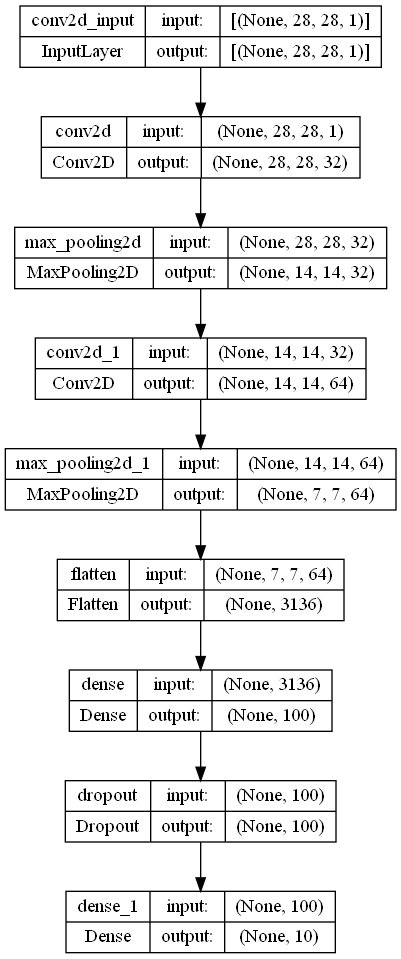

In [8]:
keras.utils.plot_model(model, show_shapes=True)

신경망을 그림으로 요약 하였다.  
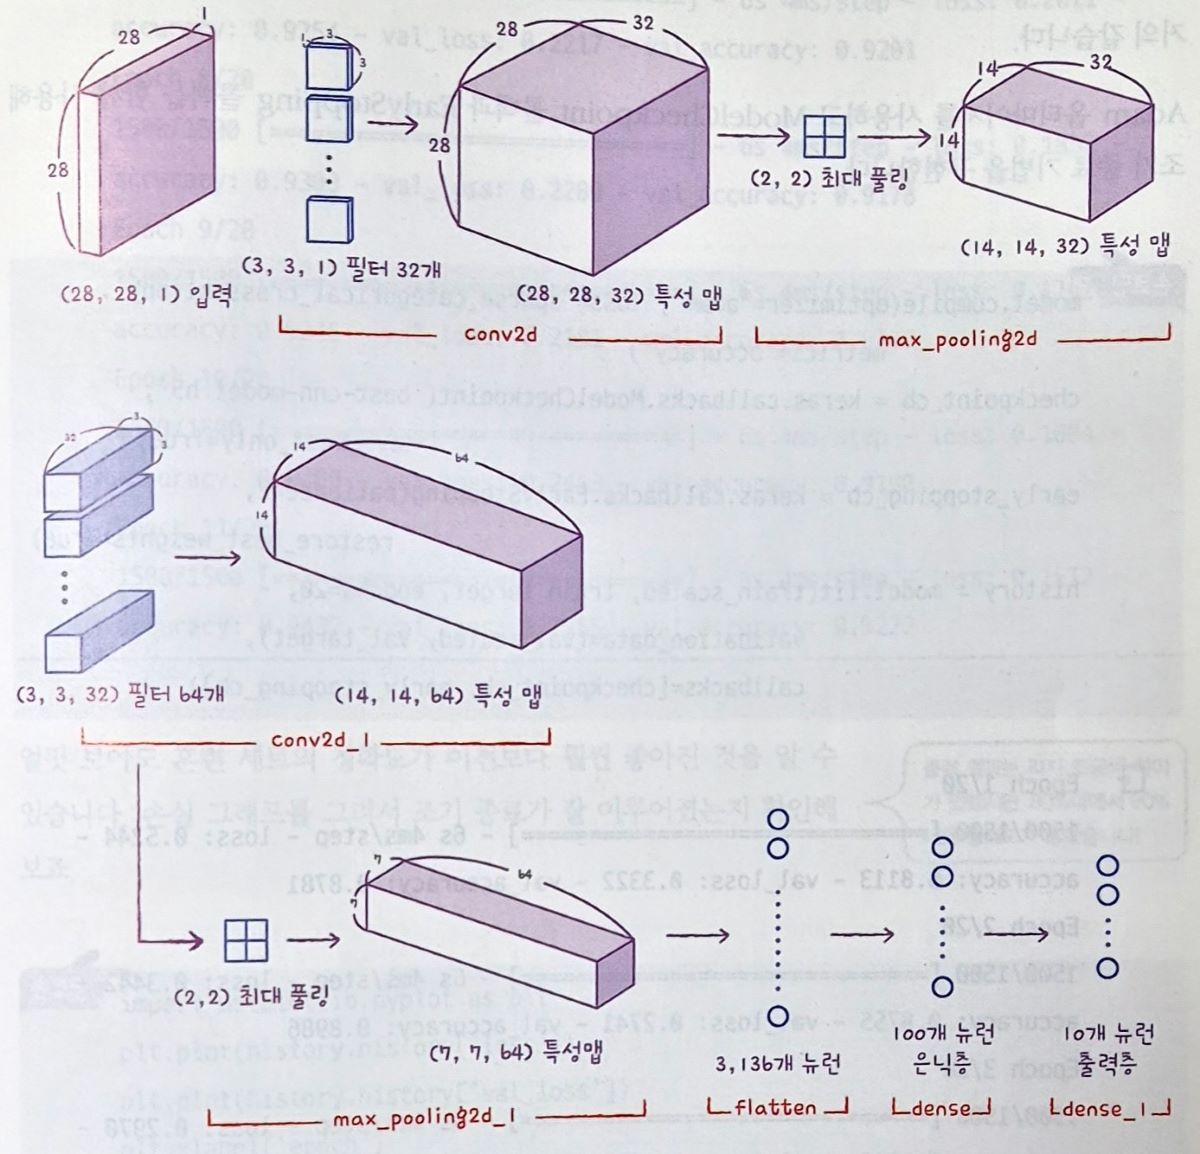  
  
모델을 컴파일하고 훈련해 보자.

### 모델 컴파일과 훈련  
Adam 옵티마이저를 사용하고 ModelCheckpoint 콜백과 EarlyStopping 콜백을 함께 사용해 조기 종료 기법을 구현한다.

In [9]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])


Epoch 1/20


1500/1500 [==============================] - 24s 14ms/step - loss: 0.5088 - accuracy: 0.8180 - val_loss: 0.3280 - val_accuracy: 0.8783
Epoch 2/20
   1/1500 [..............................] - ETA: 27s - loss: 0.4347 - accuracy: 0.8125

c:\Users\HONG\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1500/1500 [==============================] - 23s 15ms/step - loss: 0.3362 - accuracy: 0.8795 - val_loss: 0.2763 - val_accuracy: 0.8986
Epoch 3/20
1500/1500 [==============================] - 22s 15ms/step - loss: 0.2872 - accuracy: 0.8959 - val_loss: 0.2556 - val_accuracy: 0.9058
Epoch 4/20
1500/1500 [==============================] - 21s 14ms/step - loss: 0.2575 - accuracy: 0.9053 - val_loss: 0.2402 - val_accuracy: 0.9116
Epoch 5/20
1500/1500 [==============================] - 21s 14ms/step - loss: 0.2329 - accuracy: 0.9135 - val_loss: 0.2308 - val_accuracy: 0.9160
Epoch 6/20
1500/1500 [==============================] - 21s 14ms/step - loss: 0.2124 - accuracy: 0.9204 - val_loss: 0.2317 - val_accuracy: 0.9144
Epoch 7/20
1500/1500 [==============================] - 20s 13ms/step - loss: 0.1933 - accuracy: 0.9283 - val_loss: 0.2236 - val_accuracy: 0.9184
Epoch 8/20
1500/1500 [==============================] - 21s 14ms/step - loss: 0.1796 - accuracy: 0.9333 - val_loss: 0.2293 - val_accura

훈련 세트의 정확도가 이전보다 좋아졌다.(80%대 → 90%대)  
손실 그래프를 그려서 조기 종료가 잘 이루어졌는지 확인 하자.

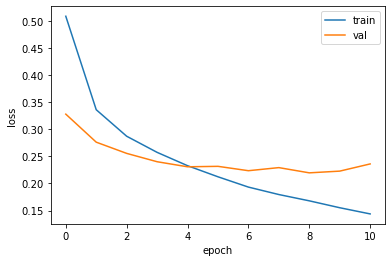

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

검증 세트에 대한 손실이 점차 감소하다가 정체되고 훈련 세트에 대한 손실은 계속 낮아진다.  
아홉 번째 에포크를 최적으로 생각할 수 있다.  
  
EarlyStopping 클래스에서 restore_best_weights 매개변수를 True로 지정했으므로 현재 model 객체가 최적의 파라미터로 복원되어 있다.  
즉 ModelCheckpoint 콜백이 저장한 best-cnn-model.h5 파일을 다시 읽을 필요가 없다.  
성능 평가를 해 보자.

In [13]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 3s 8ms/step - loss: 0.2197 - accuracy: 0.9235


[0.2196514755487442, 0.9235000014305115]

이 결과는 fit() 메서드의 출력 중 아홉 번째 에포크의 출력과 동일하다. EarlyStopping 콜백이 model 객체를 최상의 모델 파라미터로 잘 복원한 것을 알 수 있다.  
  
7장에서 다루었던 predict() 메서드를 사용해 훈련된 모델을 사용하여 새로운 데이터에 대해 예측을 만들어 보자.  
편의상 검증 세트의 첫 번째 샘플을 처음 본 이미지라고 가정한다. 맷플롯립에서는 흑백 이미지에 깊이 차원은 없다.  
따라서 (28,28,1) 크기를 (28,28)로 바꾸어 출력해야 한다.

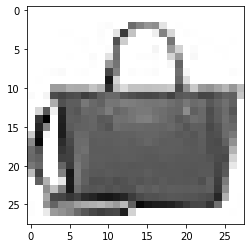

In [15]:
plt.imshow(val_scaled[0].reshape(28,28), cmap='gray_r')
plt.show()

In [17]:
preds = model.predict(val_scaled[0:1])
print(preds)

1/1 [==============================] - 0s 133ms/step
[[5.5555150e-21 2.6251217e-28 1.4496416e-20 8.2017315e-19 8.3998056e-22
  1.4978922e-18 2.3532733e-17 2.3597988e-18 1.0000000e+00 4.5246747e-20]]


#### 왜 슬라이싱을 사용?  
predict() 메서드에 데이터를 전달할 때 val_scaled[0]로 쓰지 않고 val_scaled[0:1]와 같이 슬라이싱을 사용했다.  
케라스의 fit(), predict(), evaluate() 메서드는 모두 입력의 첫 번째 차원이 배치 차원일 것으로 기대한다.  
따라서 샘플 하나를 전달할 때 (28,28,1)이 아니라 (1,28,28,1) 크기를 전달해야 한다.  
배열 슬라이싱은 인덱싱과 다르게 선택된 원소가 하나이더라도 전체 차원이 유지되어 (1,28,28,1) 크기를 만든다.

출력 결과를 보면 아홉 번째 값이 1이고 다른 값은 0에 가깝다. 막대그래프로 표현해 보자.

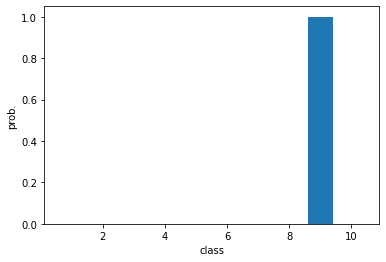

In [18]:
plt.bar(range(1,11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

아홉 번째 클래스가 실제로 무엇인지는 패션 MNIST 데이터셋의 정의를 참고해야 한다.  
7장에서 패션 MNIST 데이터셋의 레이블을 확인했기 때문에 레이블을 리스트로 저장한다.

In [19]:
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트 ', '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

클래스 리스트가 있으면 레이블을 출력하기 용이하다. preds 배열에서 가장 큰 인덱스를 찾아 classes 리스트의 인덱스로 사용하면 된다.

In [20]:
import numpy as np
print(classes[np.argmax(preds)])

가방


샘플을 가방으로 잘 예측하였다.  
테스트 세트로 합성곱 신경망의 성능을 알아보자.  
  
훈련 세트와 검증 세트에서 했던 것 처럼 픽셀값의 범위를 0~1 사이로 바꾸고 이미지 크기를 (28,28)에서 (28,28,1)로 변경한다.

In [21]:
test_scaled = test_input.reshape(-1,28,28,1)/255.0

evaluate() 메서드로 성능을 측정한다.

In [22]:
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 1s 3ms/step - loss: 0.2377 - accuracy: 0.9163


[0.23765946924686432, 0.9162999987602234]

예상대로 테스트 세트에서의 점수는 검증 세트보다 조금 더 작다. 실제 약 91%의 성능을 기대할 수 있겠다.

### 케라스 API로 합성곱 신경망 구현(정리)  
이번 절에서는 케라스 API를 사용해 합성곱 신경망을 만들어 보았다.  
케라스의 Conv2D 클래스를 사용해 32개의 필터와 64개의 필터를 둔 2개의 합성곱 층을 추가했다. 두 합성곱 층 다음에는 모두 (2,2) 크기의 최대 풀링 층을 배치했다.  
두 번째 풀링 층을 통과한 특성 맵을 펼친 다음 밀집 은닉층에 연결하고 최종적으로 10개의 뉴런을 가진 출력층에서 샘플에 대한 확률을 출력했다.  
  
7장에서 사용했던 조기 종료 기법을 사용해 모델을 훈련한 다음 검증 세트로 최적의 에포크에서 성능을 평가했다.  
또 샘플 데이터 하나를 선택해 예측 클래스를 출력하는 방법을 살펴보았다.  
  
마지막으로 테스트 세트를 사용해 최종 모델의 일반화 성능을 평가했다. 항상 테스트 세트는 모델을 출시하기 직전 딱 한 번만 사용해야 한다. 그렇지 않다면 모델을 실전에 투입했을 때 성능을 올바르게 예측하지 못한다.  
  
합성곱 신경망은 이미지를 주로 다루기 때문에 각 층의 출력을 시각화하기 좋다. 다음 절에서는 합성곱 층의 가충치와 특성 맵을 시각화하여 신경망이 학습한 내용을 고찰해 보겠다.

### Tensorflow  
- **Conv2D**  
입력의 너비와 높이 방향의 합성곱 연산을 구현한 클래스.  
<font color=teal>첫 번째 매개변수</font>는 합성곱 필터의 개수이다.  
<font color=teal>kernel_size</font> 매개변수는 필터의 커널 크기를 지정한다. 가로세로 크기가 같은 경우 정수 하나로, 다른 경우 정수의 튜플로 지정할 수 있다.  
일반적으로 커널의 가로세로 크기는 동일하다. 커널의 깊이는 입력의 깊이와 동일하기 때문에 따로 지정하지 않는다.  
<font color=teal>stride</font> 매개변수는 필터의 이동 간격을 지정한다. 가로세로 크기가 같은 경우 정수 하나로, 다른 경우 정수의 튜플로 지정할 수 있다. 일반적으로 가로세로 스트라이드 크기는 동일하다. 기본값은 1이다.  
<font color=teal>padding</font> 매개변수는 입력의 패딩 타입을 지정한다. 기본값 'valid'는 패딩을 하지 않는다. 'same'은 합성곱 층의 출력의 가로세로 크기를 입력과 동일하게 맞추도록 입력에 패딩을 추가한다.  
<font color=teal>activation</font> 매개변수는 합성곱 층에 적용할 활성화 함수를 지정한다.
<br><br/>

- **MaxPooling2D**  
입력의 너비와 높이를 줄이는 풀링 연산을 구현한 클래스.  
<font color=teal>첫 번째 매개변수</font>는 풀링의 크기를 지정하며, 가로세로 크기가 같은 경우 정수 하나로, 다른 경우 튜플로 지정할 수 있다.  
일반적으로 풀링의 가로세로 크기는 같게 지정한다.  
<font color=teal>stride</font> 매개변수는 풀링의 이동 간격을 지정한다. 기본값은 풀링의 크기와 동일하다. 즉 입력 위를 겹쳐서 풀링하지 않는다.  
<font color=teal>padding</font> 매개변수는 입력의 패딩 타입을 지정한다. 기본값 'valid'는 패딩을 하지 않는다. 'same'은 합성곱 층의 출력의 가로세로 크기를 입력과 동일하게 맞추도록 입력에 패딩을 추가한다.
<br><br/>

- **plot_model()**  
케라스 모델 구조를 주피터 노트북에 그리거나 파일로 저장한다.  
<font color=teal>첫 번째 매개변수</font>에 케라스 모델 객체를 전달한다.  
<font color=teal>to_file</font> 매개변수에 파일 이름을 지정하면 그림을 파일로 저장한다.  
<font color=teal>show_shapes</font> 매개변수를 True로 지정하면 층의 입력, 출력 크기를 표시한다. 기본값은 False이다.  
<font color=teal>show_layer_names</font> 매개변수를 True로 지정하면 층 이름을 출력한다. 기본값이 True이다.

### matplotlib  
- **bar()**  
막대 그래프를 출력한다.  
<font color=teal>첫 번째 매개변수</font>에 x축의 값을 리스트나 넘파이 배열로 전달한다.  
<font color=teal>두 번째 매개변수</font>에 막대의 y축 값을 리스트나 넘파이 배열로 전달한다.  
<font color=teal>width</font> 매개변수에서 막대의 두께를 지정할 수 있다. 기본값은 0.8이다.